# Multiplexing signals and generating AM signal

In [30]:
import numpy as np
import scipy.io.wavfile as iowav
from scipy import signal
import resampy
import matplotlib.pyplot as plt
import wave as wv

Fs Audio 1:  8000 
Fs Audio 2:  8000


Text(0, 0.5, 'Magnitude')

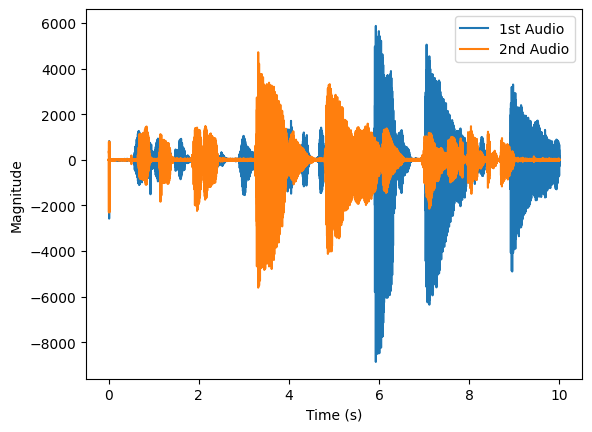

In [50]:
[Fs1, audio1] = iowav.read('../data/audio1.wav')
[Fs2, audio2] = iowav.read('../data/audio2.wav')
t = 10 # 10 seconds of audio
audio1 = audio1[0:10*Fs1]
audio2 = audio2[0:10*Fs2]
print("Fs Audio 1: ",Fs1,"\nFs Audio 2: ",Fs2)
plt.figure()
plt.plot(np.arange(len(audio1))/Fs1, audio1, label="1st Audio")
plt.plot(np.arange(len(audio2))/Fs2, audio2, label="2nd Audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")

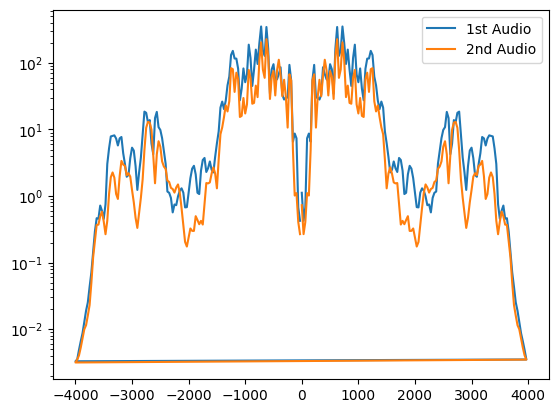

In [32]:
# Plot signal power and frequencies
xf1, yp1 = signal.welch(audio1, Fs1, return_onesided=False)
xf2, yp2 = signal.welch(audio2, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(xf1, yp1, label="1st Audio")
plt.semilogy(xf2, yp2, label="2nd Audio")
plt.legend()
plt.show()

In [33]:
# Resampling signal
U = 16 # Upsampling factor
Fs_tx = U*Fs1
carrier_if = 600e3
carriers = np.array([610, 620]) * 1e3
BW_am = 5e3 # 5kHz baseband or 10 kHz passband
f_max = carriers[-1] - carrier_if + BW_am
audio1_resampled = signal.resample(audio1, int(Fs_tx*t))
audio2_resampled = signal.resample(audio2, int(Fs_tx*t))

In [34]:
# Multiplexing signals x1 and x2 into x considering carrier frequencies 610kHz and 620kHz, respectively
h = 0.5
n = np.arange(0, t, 1/Fs_tx)
A1 = np.max(np.abs(audio1_resampled))/h
A2 = np.max(np.abs(audio2_resampled))/h
phase = np.pi
x = (A1+audio1_resampled)*np.cos(2*np.pi*n*carriers[0]+phase)+(A2+audio2_resampled)*np.cos(2*np.pi*n*carriers[1]+phase)

In [35]:
# Creating a noise in according to SNR value and inserting into signal x
SNR_db = 90
power_x = np.mean(np.power(x,2))
noise = np.sqrt(power_x/(np.power(10,SNR_db/10)))*np.random.randn(len(x))
noise_power = np.mean(np.power(noise,2))
rx = x#+noise
print(10*np.log10(power_x/noise_power))

89.9963132531112


# Demodulating AM signal

In [36]:
# Recovering from carrier frequency to the baseband
rbb1 = rx*np.cos(2*np.pi*n*carriers[0]+phase)
rbb2 = rx*np.cos(2*np.pi*n*carriers[1]+phase)

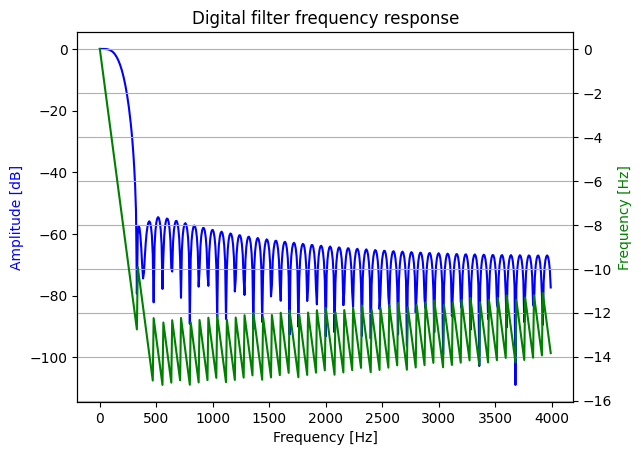

Group Delay:  49.49999999999999


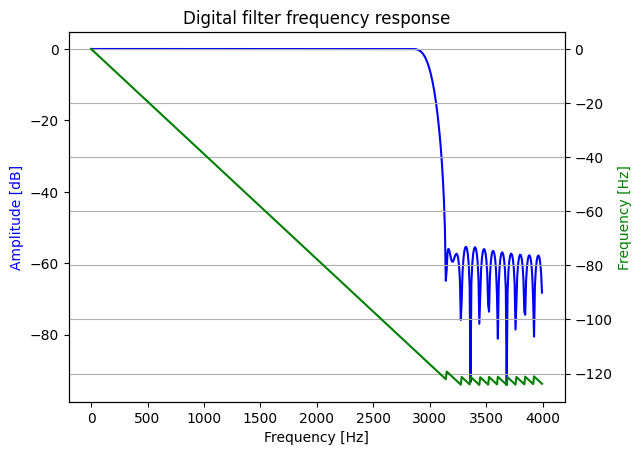

Group Delay:  49.499999999999964


In [37]:
# Filtering the signal at baseband
Foff = 3e3 # Filter cutoff frequency
filter_taps = 100
B = signal.firwin(filter_taps,Foff/(Fs_tx/2), window = "hamming")#, pass_zero = 'lowpass')
B2 = signal.firwin(filter_taps,Foff/(Fs1/2), window = "hamming")#, pass_zero = 'lowpass')
for filter in [B, B2]:
	w, h = signal.freqz(filter)
	fig, ax1 = plt.subplots()
	ax1.set_title('Digital filter frequency response')
	ax1.plot(w*Fs1/(2*np.pi), 20 * np.log10(abs(h)), 'b')
	ax1.set_ylabel('Amplitude [dB]', color='b')
	ax1.set_xlabel('Frequency [Hz]')
	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	ax2.plot(w*Fs1/(2*np.pi), angles, 'g')
	ax2.set_ylabel('Frequency [Hz]', color='g')
	ax2.grid()
	ax2.axis('tight')
	plt.show()
	print('Group Delay: ', signal.group_delay((filter, 1))[1][0])

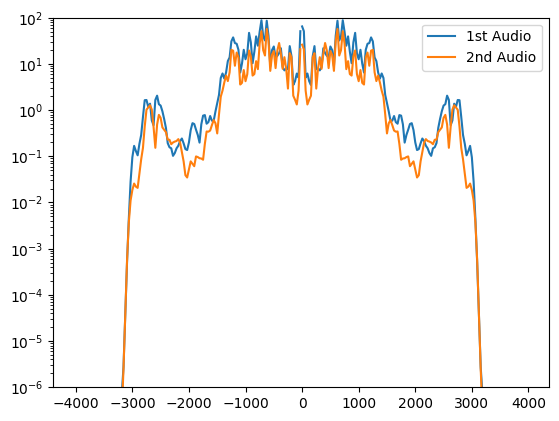

In [38]:
# Apply the filter on received signals with upsampling
rbb1 = signal.lfilter(B, 1, rbb1)
rbb2 = signal.lfilter(B, 1, rbb2)

# Resampling signals to 8kHz
rbb1_resampled = signal.resample(rbb1, int(Fs1*t))
rbb2_resampled = signal.resample(rbb2, int(Fs2*t))

# Using only the magnitude of the signal
mx1 = np.abs(rbb1_resampled)
mx2 = np.abs(rbb2_resampled)

# Filtering again using original FS
mx1_filtered = signal.lfilter(B2, 1, mx1)
mx2_filtered = signal.lfilter(B2, 1, mx2)

# removing average noise
mx1_denoised = mx1_filtered - np.mean(mx1_filtered)
mx2_denoised = mx2_filtered - np.mean(mx2_filtered)

fmx1, ymx1 = signal.welch(mx1_denoised, Fs1, return_onesided=False)
fmx2, ymx2 = signal.welch(mx2_denoised, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(fmx1, ymx1, label="1st Audio")
plt.semilogy(fmx2, ymx2, label="2nd Audio")
plt.ylim([1e-6, 1e+2])
plt.legend()
plt.show()
iowav.write('../data/test.wav', Fs1, (mx1_denoised).astype(np.int16))

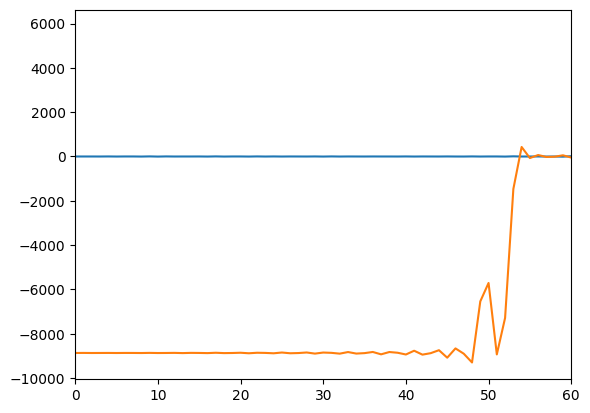

In [45]:
plt.figure()
plt.plot(audio1, label="Transmitted signal")
plt.plot(mx1_denoised, label="Received signal")
plt.xlim(0,60)
plt.show()

In [ ]:
# Subtracting the mean of the signal (due to the addition of AM component at DC level, variables A1 and A2)
sig_filtered1 = sig_filtered1 - np.mean(sig_filtered1)
sig_filtered2 = sig_filtered2 - np.mean(sig_filtered2)

# removing filter group delay from filters
# sig_filtered1 = np.append(sig_filtered1[np.ceil(grp_delay*2).astype(np.int16):], np.zeros(np.ceil(grp_delay*2).astype(np.int16)))
# sig_filtered2 = np.append(sig_filtered2[np.ceil(grp_delay*2).astype(np.int16):], np.zeros(np.ceil(grp_delay*2).astype(np.int16)))

sig_filtered1 = np.append(sig_filtered1[22:], np.zeros(22))
sig_filtered2 = np.append(sig_filtered2[22:], np.zeros(22))

#normalização doida
sig_filtered1 = np.where(np.abs(sig_filtered1)>4000.0, 0, sig_filtered1)

In [ ]:

power_rcv_signal1 = np.mean(np.power(sig_filtered1, 2))
power_ori_signal1 = np.mean(np.power(audio1, 2))
power_noise1 = np.mean(np.power((sig_filtered1-audio1), 2))
snr_rcv_signal = 10*np.log10(power_rcv_signal1/power_noise1)
print('Power received signal 1 = ', power_rcv_signal1, '\nPower original signal 1 = ', power_ori_signal1, '\nPower noise 1 = ', power_noise1, '\nSNR 1 = ', snr_rcv_signal)

In [ ]:
plt.figure()
# plt.plot(np.arange(len(sig_filtered2))/Fs2, sig_filtered2, label="2nd Audio")
plt.plot(np.arange(len(audio1))/Fs1, audio1, '-y', label="1st Audio")
plt.plot(np.arange(len(sig_filtered1))/Fs1, sig_filtered1, '-b', label="1st received Audio")
plt.plot(np.arange(len(audio1))/Fs1, audio1-sig_filtered1, '-r', label="Error")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")

In [ ]:
y = np.correlate(sig_filtered1, audio1,"full")
plt.figure()
plt.plot(np.arange(-len(y)/2,len(y)/2), y)
plt.show()

In [ ]:
np.argmax(y)

In [ ]:
np.max(np.abs(audio1))

In [ ]:
np.max(abs(sig_filtered1))

In [ ]:
iowav.write('../data/test.wav', Fs1, (sig_filtered1).astype(np.int16))